### LGBM

- tree model preprocessing 한 데이터 적용
- optuna 이용한 하이퍼파라미터 최적화

In [13]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


In [14]:
# 모델
from sklearn.ensemble import RandomForestClassifier

# Dataset 관련
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5_for_treemodel.csv')
#df = df.iloc[:1000]
#df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

before:  (149559, 1618)


In [16]:
df['highest_possible_return_bf_1']

0              NaN
1         1.000000
2         1.000000
3         0.999778
4         0.999911
            ...   
149554    1.000361
149555    1.000295
149556    1.000361
149557    1.000393
149558    1.000295
Name: highest_possible_return_bf_1, Length: 149559, dtype: float64

In [18]:
df

,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,ending_price,lowest_price,highest_price,ob_end_ap_0,...,highest_possible_return_bf_11,highest_possible_return_bf_12,highest_possible_return_bf_13,highest_possible_return_bf_14,highest_possible_return_bf_15,highest_possible_return_bf_16,highest_possible_return_bf_17,highest_possible_return_bf_18,highest_possible_return_bf_19,highest_possible_return_bf_20
0,0.000000,0.000089,0.000089,1.468656,0.747351,22568000.0,22570000.0,22568000.0,22570000.0,22570000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000089,0.000089,0.567585,0.027857,22568000.0,22570000.0,22568000.0,22570000.0,22570000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.000576,0.000044,0.000620,1.677093,0.146635,22570000.0,22570000.0,22557000.0,22571000.0,22571000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000044,0.000443,0.000488,2.439677,0.751995,22557000.0,22567000.0,22556000.0,22567000.0,22567000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.000443,0.000000,0.000443,2.345821,-0.915608,22565000.0,22555000.0,22555000.0,22565000.0,22565000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149554,0.000000,0.000033,0.000033,0.153247,0.802207,30507000.0,30508000.0,30507000.0,30508000.0,30509000.0,...,1.000853,1.000918,1.001575,1.000820,1.001542,1.000623,1.000459,1.000393,1.000393,1.000393
149555,-0.000033,0.000000,0.000033,0.879080,-0.505112,30509000.0,30509000.0,30508000.0,30509000.0,30509000.0,...,1.000853,1.000853,1.000918,1.001575,1.000820,1.001542,1.000623,1.000459,1.000393,1.000393
149556,-0.000033,0.000000,0.000033,0.412820,0.509523,30509000.0,30508000.0,30508000.0,30509000.0,30509000.0,...,1.000295,1.000853,1.000853,1.000918,1.001575,1.000820,1.001542,1.000623,1.000459,1.000393
149557,0.000000,0.000033,0.000033,2.141030,0.785751,30509000.0,30510000.0,30509000.0,30510000.0,30513000.0,...,1.000328,1.000295,1.000853,1.000853,1.000918,1.001575,1.000820,1.001542,1.000623,1.000459


In [17]:
(df.columns == 'lowest_return').sum()

1

In [19]:
# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
# target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
# df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
# print("after: ", df.shape)
#print(df.head())

# 독립변수 카테고리화
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
#scaler = MinMaxScaler()
X = df.drop(columns=['returns_next10m']) # 위 변수를 제외한 모든 변수
y = df['returns_next10m'].values # 종속변수

In [22]:
# 시계열 train, test split
split = int(len(df) * 0.8)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# RandomForestClassifier 모델 생성 및 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred1 = model.predict(X_test)

0(negative) target ratio: 0.5142102447505684
1(positive) target ratio: 0.4857897552494316
-----------------------------------
Accuracy: 0.5829
Precision: 0.7566
Recall: 0.2085
F1 Score: 0.327
-----------------------------------


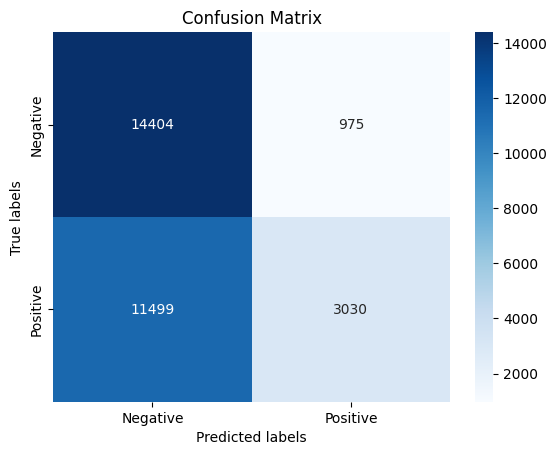

In [24]:
# 분류 성능 확인
predictions = np.array(pred1)
target_np = np.array(y_test)

# Data imbalance check
print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
print('-----------------------------------')

# metrics
accuracy = accuracy_score(target_np, predictions) # 정확도 계산
precision = precision_score(target_np, predictions) # 정밀도 계산
recall = recall_score(target_np, predictions) # 재현율 계산
f1 = f1_score(target_np, predictions) # F1 스코어 계산

print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')
print('-----------------------------------')

# confusion matrix
cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
fig, ax = plt.subplots() # 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()


In [25]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

def objective(trial):
    # 탐색할 파라미터 설정
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # RandomForest 모델 생성
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf, random_state=42)
    
    # 교차 검증을 사용한 모델 평가
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    # 프루닝을 위한 조건 체크
    trial.report(score, trial.number)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return score

# Optuna 최적화 with MedianPruner
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10, interval_steps=1)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

# 최적 파라미터 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# 최적의 파라미터를 사용한 모델 학습 및 평가
best_params = study.best_trial.params
best_clf = RandomForestClassifier(**best_params).fit(X_train, y_train)
print("Test Accuracy:", best_clf.score(X_test, y_test))


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-04-04 17:54:30,272] A new study created in memory with name: no-name-034c1b1c-9e8f-4016-a9d1-5a4dda2f4072
[I 2024-04-04 17:54:41,925] Trial 0 finished with value: 0.5028462522255936 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_split': 0.6338285133533031, 'min_samples_leaf': 0.3385233663188685}. Best is trial 0 with value: 0.5028462522255936.
[I 2024-04-04 17:54:56,922] Trial 1 finished with value: 0.5028462522255936 and parameters: {'n_estimators': 530, 'max_depth': 28, 'min_samples_split': 0.8779032721781677, 'min_samples_leaf': 0.19313850370595237}. Best is trial 0 with value: 0.5028462522255936.
[W 2024-04-04 17:58:49,027] Trial 2 failed with parameters: {'n_estimators': 987, 'max_depth': 24, 'min_samples_split

KeyboardInterrupt: 

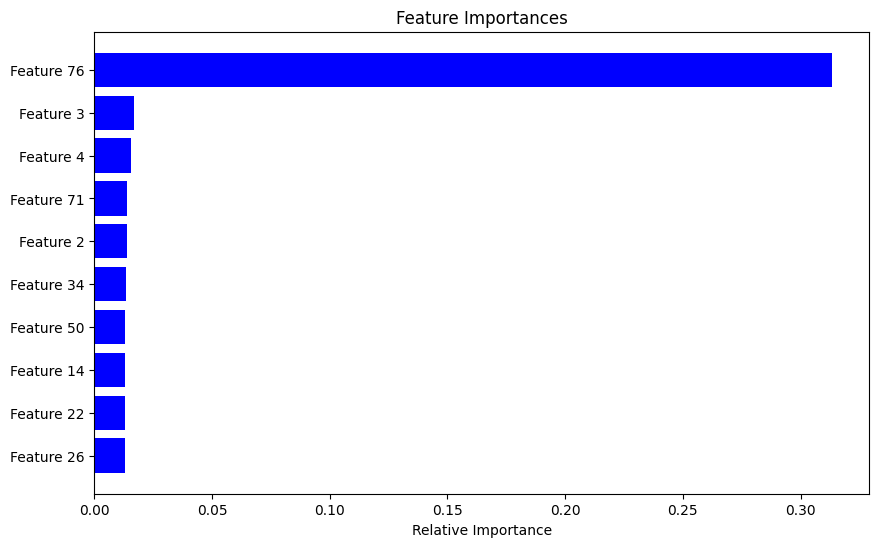

In [10]:
# feature importance 추출 및 시각화
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_n_indices = indices[:10]

# 상위 10개의 특성 이름 및 중요도
top_features = [f'Feature {i}' for i in top_n_indices]
top_importances = feature_importances[top_n_indices]

# 시각화
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(top_n_indices)), top_importances[::-1], color='b', align='center')
plt.yticks(range(len(top_n_indices)), np.array(top_features)[::-1])
plt.xlabel('Relative Importance')
plt.show()

In [19]:
# top 10 cols by feature importance
top_10_cols = df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id']).columns[[76, 3, 4, 71, 2, 34, 50, 14, 22, 26]]

for col in top_10_cols:
    print(col)

highest_possible_return
trade_vol
volume_power
ob_end_bias_4
high_low_gap
ob_end_as_6
ob_end_as_10
ob_end_as_1
ob_end_as_3
ob_end_as_4
